In [71]:
import requests
import json
import numpy as np
from loguru import logger
import h5py
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from pathlib import Path
from sklearn.model_selection import train_test_split 
from typing import Any
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import io
plt.style.use('dark_background')

In [56]:
BASE_DIR =  Path().resolve().parent
ARTIFACTS_DIR = BASE_DIR / "src" / "artifacts"
ARTIFACTS_DIR

PosixPath('/home/srirama/sr_proj/EmotionAnalysis/src/artifacts')

In [57]:
def load_h5(file_path):
    with h5py.File(file_path, "r") as f:
        X_ds: Any = f["X"]
        y_ds: Any = f["y"]
        X = X_ds[:]
        y = y_ds[:]
    logger.info(f"Dataset loaded from {file_path}")
    return X, y

def load_tokenizer(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        tok_dict = json.load(f)
    logger.info(f"Tokenizer loaded from {file_path}")
    return tokenizer_from_json(tok_dict)

In [58]:
# Load hdf5 dataset directly
X,y = load_h5(str(ARTIFACTS_DIR / "data.h5"))
logger.info(f"Loaded data -> X: shape={X.shape}, dtype={X.dtype} ; y: shape={y.shape}, dtype={y.dtype}")
# Load tokenizer
tokenizer = load_tokenizer(str(ARTIFACTS_DIR / "tokenizer.json"))
# Train-test split (same logic you used before)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
logger.info(f"Train size : {X_train.shape[0]} | Val size : {y_val.shape[0]}")

2025-11-23 17:30:44.601 | INFO     | __main__:load_h5:7 - Dataset loaded from /home/srirama/sr_proj/EmotionAnalysis/src/artifacts/data.h5
2025-11-23 17:30:44.604 | INFO     | __main__:<module>:3 - Loaded data -> X: shape=(30000, 75), dtype=int32 ; y: shape=(30000, 4), dtype=float64
2025-11-23 17:30:44.639 | INFO     | __main__:load_tokenizer:13 - Tokenizer loaded from /home/srirama/sr_proj/EmotionAnalysis/src/artifacts/tokenizer.json


2025-11-23 17:30:44.727 | INFO     | __main__:<module>:8 - Train size : 24000 | Val size : 6000


In [60]:
URL = "http://localhost:8501/v1/models/rnn_classifier:predict"

In [61]:
import rich
data = json.dumps(
    {
        "signature_name": "serving_default",
        "instances": X_val.tolist()  # must be python lists
    }
)
headers = {"content-type": "application/json"}
response = requests.post(URL, data=data, headers=headers)
rich.print(response)

<Response [200]>

In [62]:
preds = json.loads(response.text)["predictions"]
preds

[[0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665194, 0.250801533, 0.266554683, 0.309978634],
 [0.172665

In [63]:
y_val

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(6000, 4))

In [ ]:
# Convert preds -> flat numpy
preds = np.argmax(preds, axis=1).flatten()
y_val = np.argmax(y_val, axis=1).flatten()

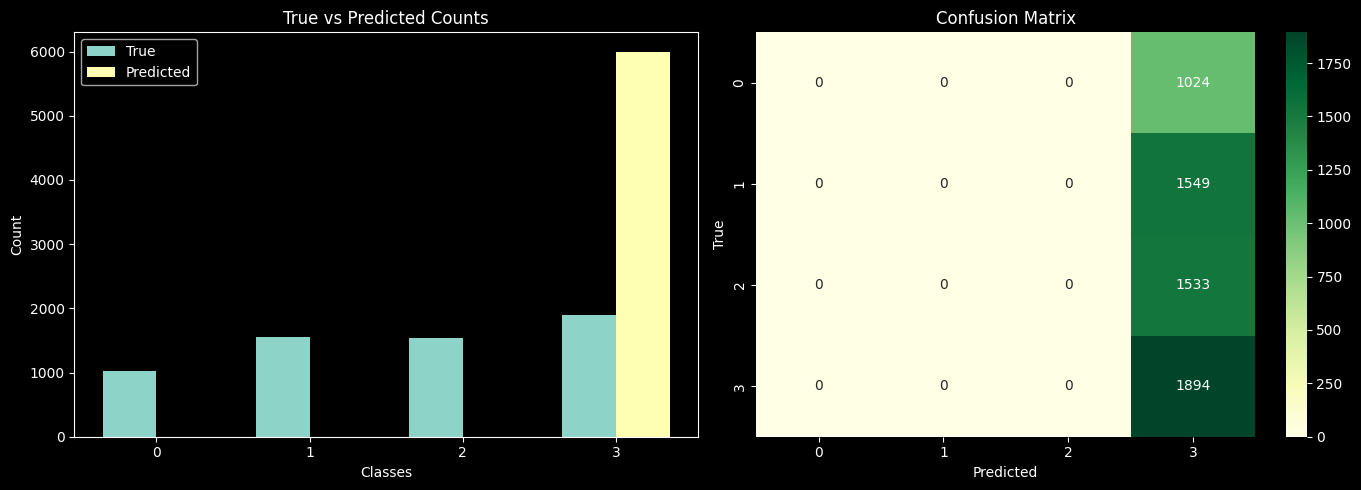

In [74]:
classes = np.unique(np.concatenate([y_val, preds]))
y_counts = [np.sum(y_val == c) for c in classes]
pred_counts = [np.sum(preds == c) for c in classes]
x = np.arange(len(classes))
width = 0.35

# Create 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot on left
axes[0].bar(x - width/2, y_counts, width, label="True")
axes[0].bar(x + width/2, pred_counts, width, label="Predicted")
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes)
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Count")
axes[0].set_title("True vs Predicted Counts")
axes[0].legend()

# Confusion matrix on right
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGn", ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()
